# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *

paths_to_create_delete = [path_figures]

distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.


### Utility functions ###

def Dz_from_Da(a):
    z =  - a * sin(deg2rad(angle_incidence)) / sin(deg2rad(data.opt[2]))
    return z * channel_distance

def Dz_from_Ds(s):
    z = s * sin(deg2rad(angle_incidence)) / cos(deg2rad(data.opt[2]))
    return z * channel_distance

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [5]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5

Shape of data
-------------
x: 140, y: 188, channels: 1280

Initial calibration
-------------------
a = -1172.8, s = 2053.1, beta = 50.710
Theta range: [20.974350647292493, 53.699886668557056]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [6]:
qtl = 0.9997

data.correct_quantile_pixels(qtl)

8 pixels out of 26320 were corrected.


# Read XRF element maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [7]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 22 images: Al_K, Au_L, Ba_L, Ca_K, Cl_K, Co_K, Cr_K, Cu_K, Fe_K, Hg_L, Hg_M, K_K, Mn_K, P_K, Pb_L, Pb_M, S_K, Sn_L, Sr_K, Ti_K, V_K, Zn_K

Shape of XRF element maps
-------------------------
x: 140, y: 188


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [8]:
#qtl = 0.995

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

6 pixels out of 26320 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [9]:
hydrocerussite = database['Hydrocerussite'][0].select_peaks([]) #[i for i in range(15) if i != 3]
gold = database['Gold'][10].select_peaks([])
cinnabar = database['Cinnabar'][0].select_peaks([])
lead_tin_y = database['Lead-tin yellow'][0].select_peaks([])

phases_primary = [hydrocerussite, gold, cinnabar, lead_tin_y]

### Take them from file `phases_selection_primary.dat`

In [ ]:
phases_primary = phases_from_file(subfolder_output + 'phases_selection_primary.dat', database)

### Set parameters of synthetic XRD patterns
You can skip this cell and keep the preset values of the parameters.

In [10]:
min_theta = 20
max_theta = 53
min_intensity = 0.1    # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2            # sigma used in the peaks of synthetic diffraction patterns

### Check the number of tabulated peaks given by chosen parameters

In [10]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_primary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
                                                 first_n_peaks = first_n_peaks, distance_merge = distance_merge)[0])]
df_phases

,Phase,N. of selected peaks
0,Hydrocerussite,10
1,Gold,2
2,Cinnabar,7
3,Lead-tin yellow,9


# Search for primary phases

### Process experimental XRD pattern

In [11]:
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 2          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...
Done.
Smoothing along channels...
Done.


### Change initial calibration

In [17]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [12]:
%%time

phase_presence_method = 'adjustment_ratio'
# 'overlap_area', 'overlap_area_ratio', 'adjustment_ratio'

gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
gm = gm.search(method = phase_presence_method)

Using 8 CPUs
CPU times: user 24.6 s, sys: 2.46 s, total: 27.1 s
Wall time: 43.1 s


#### Fast mapping

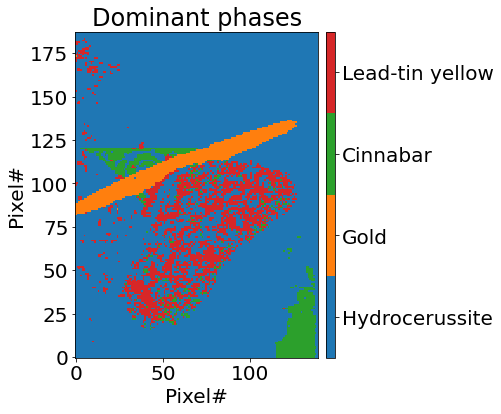

In [13]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

# Quantify phase presence

In [14]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True), ('overlap_area_ratio', False), ('adjustment_ratio', False)

phase_presence = gm.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

Using 8 CPUs
CPU times: user 7.21 s, sys: 433 ms, total: 7.64 s
Wall time: 8.32 s


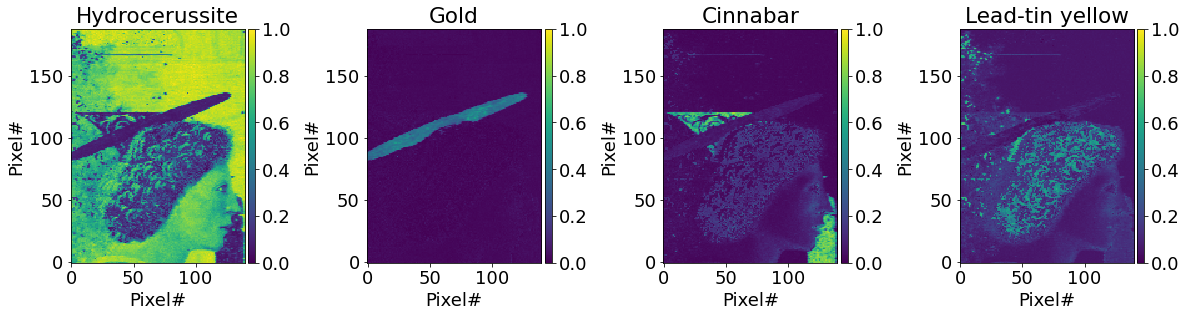

In [15]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 6 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence[..., i] / nanmax(phase_presence)
    #matrix_plot = phase_presence[..., i] / nanmax(phase_presence[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

# Select the phases for analysis
You need to choose phases among the primary ones.
You can also choose the two phases to be equal.

In [16]:
phase_reference = hydrocerussite   # this phase will be used to take a reference calibration
phase_analysis = hydrocerussite    # the calibration of this phase will be analised

### Calibration

In [17]:
%%time

phases_sel = [phase_reference, phase_analysis]
gm_sel = []
for i in [0, 1]:
    print(f'Calibrating on {phases_sel[i].label}...')
    gm_sel.append(
        GammaMap().from_data(data, phases_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    )
    gm_sel[i] = gm_sel[i].search(phase_selected = i, method = phase_presence_method)
    print('Done.')

# Phase presence
presence_phases_sel = []
for i in [0, 1]:
    idx = gm.phases.index(phases_sel[i])
    presence_phases_sel.append(phase_presence[..., idx] / phase_presence[..., idx].max())
presence_phases_sel = array(presence_phases_sel)

Calibrating on Hydrocerussite...
Using 8 CPUs
Done.
Calibrating on Hydrocerussite...
Using 8 CPUs
Done.
CPU times: user 33.3 s, sys: 5.34 s, total: 38.7 s
Wall time: 53.7 s


# Analyse the selected phase in a given area

### Select area

Area: 50 * 50 = 2500


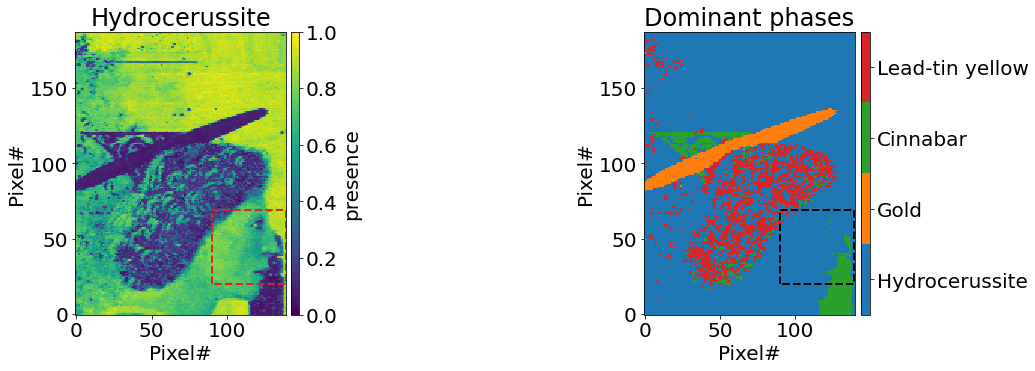

In [18]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

### Select the area ###

# All the scan
#x_min, x_max = 0, data.shape[1] - 1
#y_min, y_max = 0, data.shape[0] - 1

# Selected area
x_min, x_max = 90, 139
y_min, y_max = 20, 69

###

area_sel = (x_max - x_min + 1) * (y_max - y_min + 1)
print(f'Area: {x_max - x_min + 1} * {y_max - y_min + 1} = {area_sel}')

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phases_sel[1, ...], interpolation = 'none', vmin = 0, vmax = 1)
settings_plot(im, ax, None, None, None, None, position_colorbar, 'presence')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'tab:red', lw = 2
)
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(phase_analysis.label)

ax = axs[1]
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'black', lw = 2
)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Dominant phases')

savefig(f'{path_figures + phase_analysis.label}__selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Select conditions
Select pixels where the presence of `phase_analysis` is between the two `threshold` values

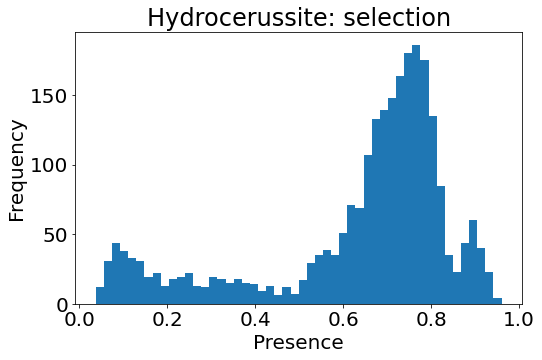

These thresholds select 2500 pixels.


In [19]:
%matplotlib inline
rcParams['font.size'] = 20

threshold = {'low': None, 'high': None} # Lower and upper threshold. You can set as None each threshold to ignore it.

###

indices_area = zeros(data.shape[:2], bool)
indices_good = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_area[y, x] = True
            if ( ((threshold['low'] is None) or (presence_phases_sel[1, y, x] >= threshold['low']))  and
                ((threshold['high'] is None) or (presence_phases_sel[1, y, x] <= threshold['high']))
            ):
                indices_good[y, x] = True

presence_service = presence_phases_sel[0, ...].copy()
presence_service[~indices_good] = None
y_ref, x_ref = unravel_index(nanargmax(presence_service), presence_service.shape)
del presence_service
opt_reference = gm_sel[0].get_pixel(x_ref, y_ref).opt.copy()
                
calibration_sel_a = gm_sel[1].opt()[..., 0].copy()
calibration_sel_s = gm_sel[1].opt()[..., 1].copy()
calibration_a_diff = calibration_sel_a - opt_reference[0]
calibration_s_diff = calibration_sel_s - opt_reference[1]

calibration_sel_a[~indices_good] = None
calibration_sel_s[~indices_good] = None
calibration_a_diff[~indices_good] = None
calibration_s_diff[~indices_good] = None

a_diff_max = nanmax(absolute(calibration_a_diff))
a_diff_min = - a_diff_max
s_diff_max = nanmax(absolute(calibration_s_diff))
s_diff_min = - s_diff_max

fig, ax = subplots(figsize = (8, 5))
ax.hist(presence_phases_sel[1, indices_area].flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if (threshold['low'] is not None):
    ax.axvline(threshold['low'], c = 'black', ls = '--', lw = 2, label = 'lower')
if (threshold['high'] is not None):
    ax.axvline(threshold['high'], c = 'black', ls = '-', lw = 2, label = 'upper')
if (threshold['low'] is not None or threshold['high'] is not None):
    ax.legend(loc = 'upper right')
ax.set_xlabel('Presence')
ax.set_ylabel('Frequency')
ax.set_title(f'{phase_analysis.label}: selection')

savefig(f'{path_figures + phase_analysis.label}__selection.png', bbox_inches = 'tight', dpi = 300)
show()
print(f'These thresholds select {indices_good.sum()} pixels.')

### Distribution of `a` in selected pixels

Calibration of `phase_analysis`.

In the second histogram, we compare the calibration of `phase_analysis` in selected pixels with the calibration of `phase_reference` in the pixel where it has the maximum presence. $\Delta a$ is the difference between the two calibrations.

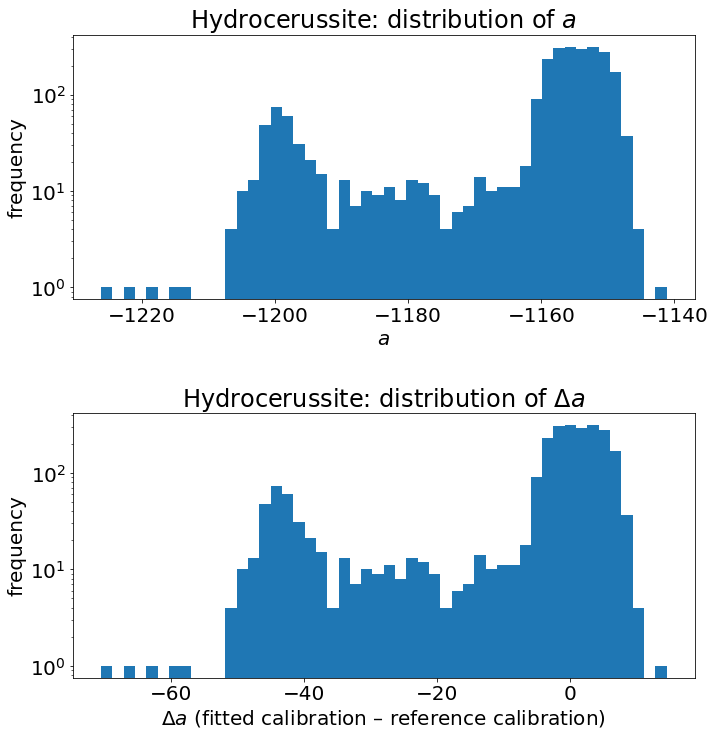

In [20]:
%matplotlib inline
rcParams['font.size'] = 20

log_y_scale = True

###

fig, axs = subplots(2, 1, figsize = (10, 10))
fig.tight_layout(h_pad = 4)

ax = axs[0]
ax.hist(calibration_sel_a.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlabel(f'$a$')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_analysis.label}: distribution of $a$')

ax = axs[1]
ax.hist(calibration_a_diff.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlabel(f'$\Delta a$ (fitted calibration – reference calibration)')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_analysis.label}: distribution of $\Delta a$')

savefig(f'{path_figures + phase_analysis.label}__histogram_a_in_selection.png', bbox_inches = 'tight', dpi = 300)
show()

### Exploration of the area

Reference pixel: (137, 68)


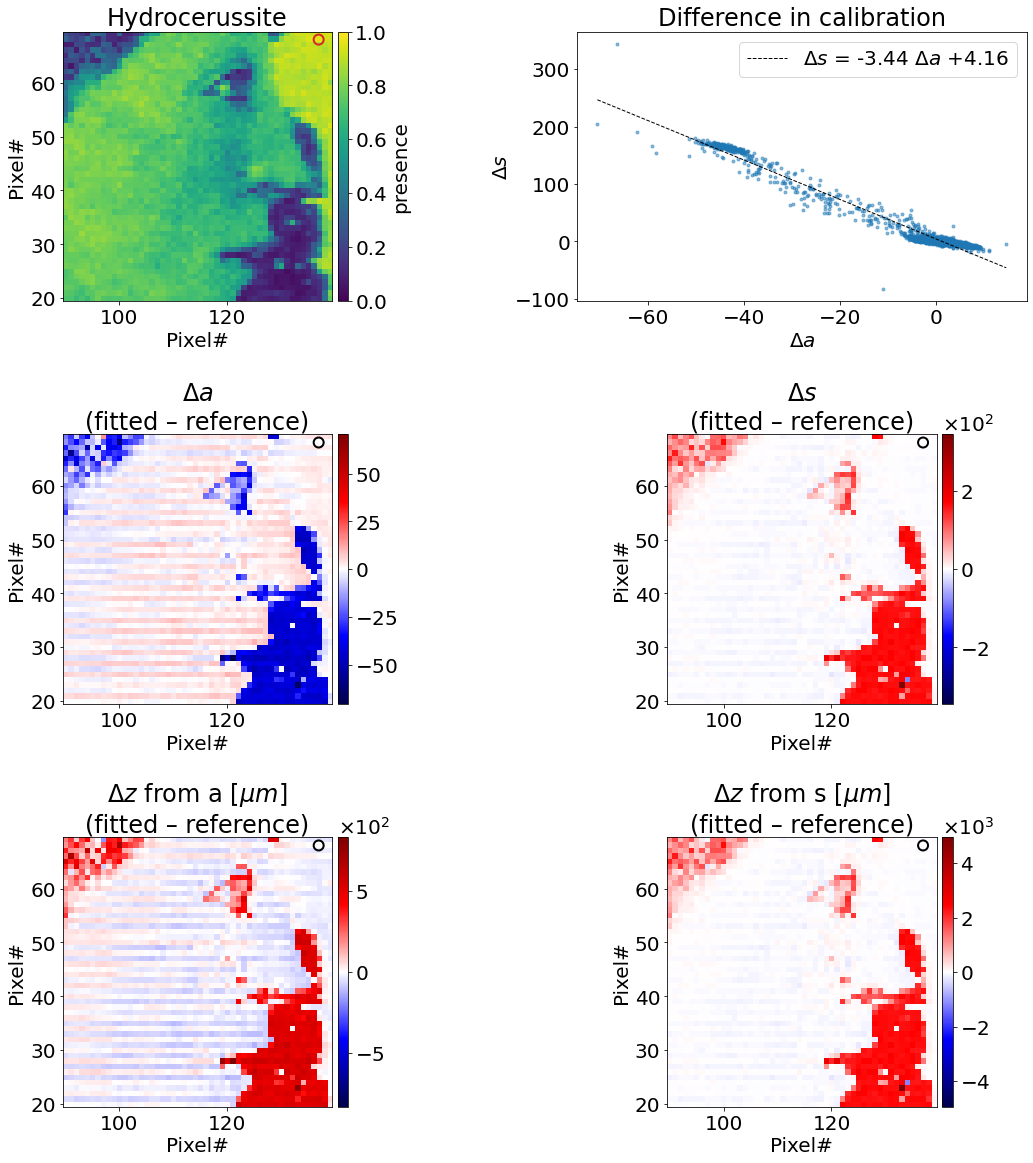

In [32]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

cmap_seismic = get_cmap('seismic').copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(3, 2, figsize = (16, 16))
fig.tight_layout(w_pad = 5, h_pad = 5)

ax = axs[0, 0]
im = ax.imshow(presence_phases_sel[1], interpolation = 'none', vmin = 0, vmax = 1)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'tab:red', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(phase_analysis.label)

ax = axs[0, 1]
lin_Da = linspace(nanmin(calibration_a_diff), nanmax(calibration_a_diff), 10)
fit_param, fit_var = curve_fit(f_linear, calibration_a_diff[indices_good], calibration_s_diff[indices_good])
ax.plot(calibration_a_diff.flatten(), calibration_s_diff.flatten(), '.', alpha = 0.5)
ax.plot(lin_Da, f_linear(lin_Da, *fit_param), ls = '--', lw = 1, c = 'black', label = f'$\Delta s$ = {fit_param[0]:.2f} $\Delta a$ {fit_param[1]:+.2f}')
ax.legend()
ax.set_xlabel(r'$\Delta a$')
ax.set_ylabel(r'$\Delta s$')
ax.set_title('Difference in calibration')

ax = axs[1, 0]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(f'$\Delta a$\n(fitted – reference)')

ax = axs[1, 1]
im = ax.imshow(calibration_s_diff, interpolation = 'none', vmin = s_diff_min, vmax = s_diff_max, cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

ax.set_title(f'$\Delta s$\n(fitted – reference)')

ax = axs[2, 0]
im = ax.imshow(Dz_from_Da(calibration_a_diff), interpolation = 'none', vmin = Dz_from_Da(a_diff_max), vmax = Dz_from_Da(a_diff_min), cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(f'$\Delta z$ from a $[\mu m]$\n(fitted – reference)')

ax = axs[2, 1]
im = ax.imshow(Dz_from_Ds(calibration_s_diff), interpolation = 'none', vmin = Dz_from_Ds(s_diff_min), vmax = Dz_from_Ds(s_diff_max), cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title(f'$\Delta z$ from s $[\mu m]$\n(fitted – reference)')

print(f'Reference pixel: ({x_ref}, {y_ref})')
savefig(f'{path_figures + phase_analysis.label}__exploration_of_area.png', bbox_inches = 'tight', dpi = 300)
show()

### Check a point

In [33]:
x_ref, y_ref

(137, 68)

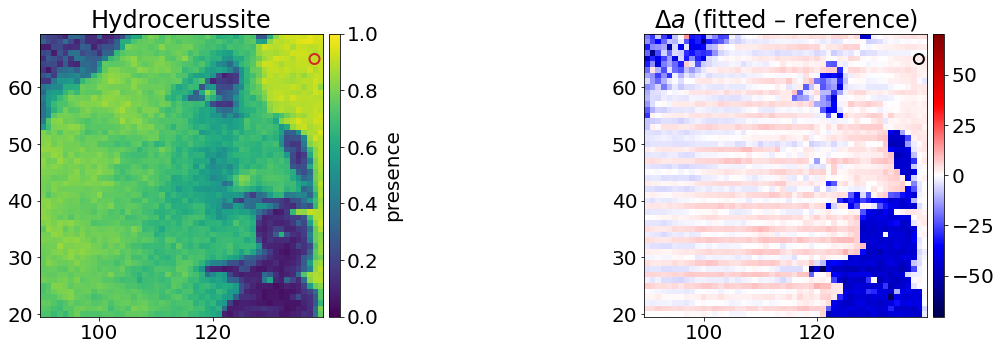

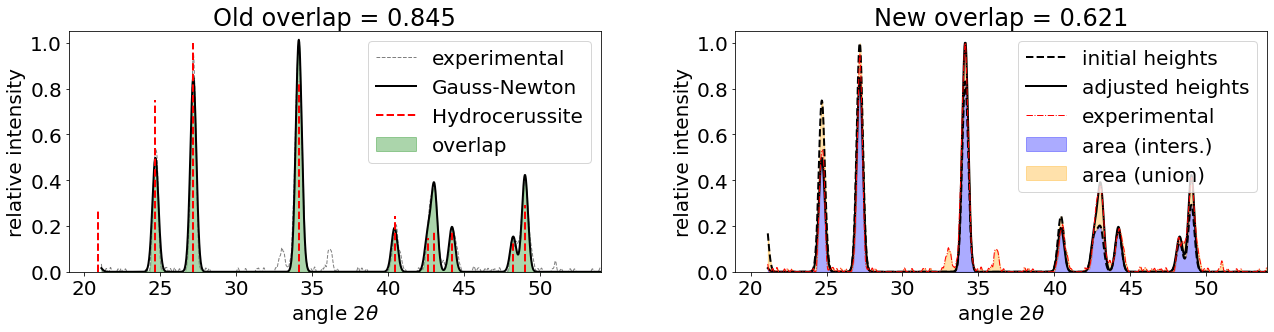

In [35]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

x, y = 138, 65

###

cmap_seismic = get_cmap('seismic').copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(1, 2, figsize = (16, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phases_sel[1, ...], interpolation = 'none', vmin = 0, vmax = 1)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'tab:red', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'presence')
ax.set_title(phase_analysis.label)

ax = axs[1]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta a$ (fitted – reference)')

show()


fig, axs = subplots(1, 2, figsize = (18, 5))
fig.tight_layout(w_pad = 4)
fig.subplots_adjust(top = 0.8)   # To shift the title

gn = gm_sel[1].get_pixel(x, y)[1]
z0 = clip(gn.z0(), None, 1)
z = clip(gn.z(), None, 1)
z_stack = stack((z0, z, gn.intensity))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1)#, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Old overlap = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.plot(gn.theta, gn.intensity, c = 'red', ls = '-.', lw = 1, label = 'experimental')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (inters.)')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (union)')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

savefig(f'{path_figures + clean_phase_name(phase_analysis.label)}__pixel_{x}_{y}.png', bbox_inches = 'tight', dpi = 300)
show()